<a href="https://colab.research.google.com/github/JetteKA/BigData/blob/master/cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


Using TensorFlow backend.


In [0]:
n_classes = 10
num_centroids = 5

epochs = 15
batch_size = 50

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [0]:
x_cluster = x_train.reshape((x_train.shape[0], -1))
x_cluster = np.divide(x_cluster, 255.)

In [0]:
kmeans = KMeans(n_clusters=n_classes, init='k-means++')

In [0]:
cluster_distance = kmeans.fit_transform(x_cluster)

In [0]:
closest_to_centroid = cluster_distance.argsort(axis=0)[:num_centroids]

In [0]:
ctc = closest_to_centroid.T

In [0]:
word_label = {0:"T-shirt/top",
              1:"Trouser",
              2:"Pullover",
              3:"Dress",
              4:"Coat",
              5:"Sandal",
              6:"Shirt",
              7:"Sneaker",
              8:"Bag",
              9:"Ankle boot"}

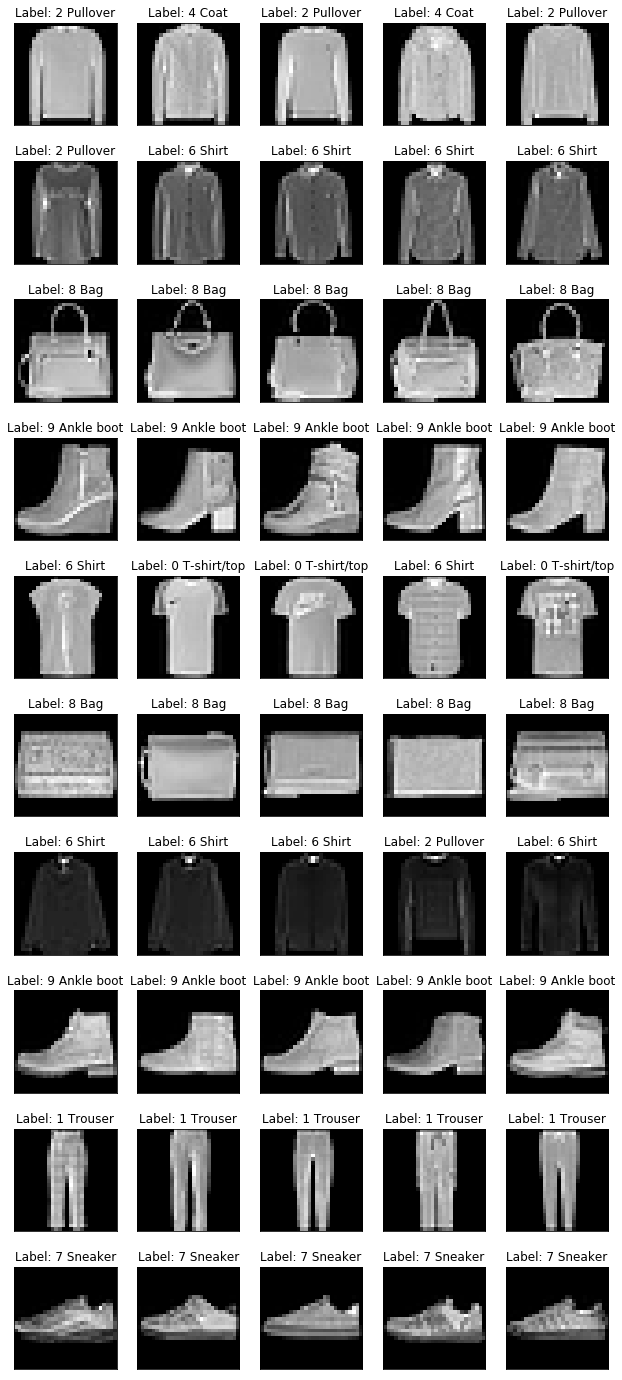

In [10]:
plt.figure(figsize = (15,25))
bottom = 0.35

x_labelled = []
y_labelled = np.empty(int(n_classes*num_centroids))
for i, index in enumerate(ctc.flatten()):

 x_labelled.append(x_train[index])
 y_labelled[i] = y_train[index]

 plt.subplots_adjust(bottom)
 
 plt.subplot(n_classes,num_centroids,i+1, xticks=[], yticks=[])
 plt.title('Label: {} {}'.format(y_train[index], word_label[y_train[index]]),fontsize = 12)
 plt.imshow(x_train[index], cmap='gray')
 plt.savefig("5centroids_cluster.png")

In [0]:
x_labelled = np.array(x_labelled)


In [0]:
x_unlabelled = np.delete(x_train, ctc.flatten(), axis=0)
y_unlabelled = np.delete(y_train, ctc.flatten())

In [0]:
def reshape_x_for_cnn(data, img_rows=img_rows, img_cols=img_cols):


  data = data.reshape(data.shape[0], img_rows, img_cols, 1)
  data = data.astype('float32')
  data /=255

  return data

def reshape_y_for_cnn(data, n_classes=n_classes):
  return keras.utils.to_categorical(data, n_classes)


In [0]:
x_test = reshape_x_for_cnn(x_test)

y_test = reshape_y_for_cnn(y_test)

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
def train_and_label(model, x_labelled, y_labelled, x_unlabelled, y_unlabelled):


  x_label_cnn = reshape_x_for_cnn(x_labelled)


  y_label_cnn = reshape_y_for_cnn(y_labelled)

  model.fit(x_label_cnn, y_label_cnn,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  x_unlabel_cnn = reshape_x_for_cnn(x_unlabelled)

  predictions = model.predict(x_unlabel_cnn)

  certainty = np.amax(predictions, axis=1)

  most_certain = certainty.argsort()[-50:]

  x_pseudo_label = []
  y_pseudo_label = []

  for i, index in enumerate(most_certain):

    x_pseudo_label.append(x_unlabelled[index])
    y_pseudo_label.append(np.argmax(predictions[index]))

  most_uncertain = certainty.argsort()[:50]

  x_label_new = []
  y_label_new = []
  for i, index in enumerate(most_uncertain):

    x_label_new.append(x_unlabelled[index])
    y_label_new.append(y_unlabelled[index])

  y_labelled = np.array(y_labelled.tolist() + y_pseudo_label + y_label_new)
  x_labelled = np.array(x_labelled.tolist() + x_pseudo_label + x_label_new)

  x_unlabelled = np.delete(x_unlabelled, np.concatenate([most_certain, most_uncertain]), axis=0)
  y_unlabelled = np.delete(y_unlabelled, np.concatenate([most_certain, most_uncertain]))

  return model, x_labelled, y_labelled, x_unlabelled, y_unlabelled


In [17]:
  print('x label:', x_labelled.shape)
  print('y label:', y_labelled.shape)  
  print('x unlabel:', x_unlabelled.shape)
  print('y unlabel:', y_unlabelled.shape)

x label: (50, 28, 28)
y label: (50,)
x unlabel: (59950, 28, 28)
y unlabel: (59950,)


In [18]:
model, x_labelled, y_labelled, x_unlabelled, y_unlabelled = train_and_label(model, x_labelled, y_labelled, x_unlabelled, y_unlabelled)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50 samples, validate on 10000 samples
Epoch 1/15





50/50 [==============================] - 3s 67ms/step - loss: 2.2782 - acc: 0.1800 - val_loss: 2.2548 - val_acc: 0.1981
Epoch 2/15
50/50 [==============================] - 0s 10ms/step - loss: 1.9675 - acc: 0.4000 - val_loss: 2.2557 - val_acc: 0.1831
Epoch 3/15
50/50 [==============================] - 0s 9ms/step - loss: 1.7373 - acc: 0.3200 - val_loss: 2.2745 - val_acc: 0.2568
Epoch 4/15
50/50 [==============================] - 0s 9ms/step - loss: 1.7144 - acc: 0.3600 - val_loss: 2.4044 - val_acc: 0.1749
Epoch 5/15
50/50 [==============================] - 0s 10ms/step - loss: 1.7030 - acc: 0.2800 - val_loss: 2.2146 - val_acc: 0.1963
Epoch 6/15
50/50 [==============================] - 0s 9ms/step - loss: 1.8022 - acc: 0.3000 - val_loss: 1.9000 - val_acc: 0.3883
Epoch 7/15
50/50 [==============================] - 0s 9ms/step - lo

In [19]:
  print('x label:', x_labelled.shape)
  print('y label:', y_labelled.shape)  
  print('x unlabel:', x_unlabelled.shape)
  print('y unlabel:', y_unlabelled.shape)

x label: (150, 28, 28)
y label: (150,)
x unlabel: (59850, 28, 28)
y unlabel: (59850,)


In [23]:
for i in range(10):
  model, x_labelled, y_labelled, x_unlabelled, y_unlabelled = train_and_label(model, x_labelled, y_labelled, x_unlabelled, y_unlabelled)
  print('x label:', x_labelled.shape)
  print('y label:', y_labelled.shape)  
  print('x unlabel:', x_unlabelled.shape)
  print('y unlabel:', y_unlabelled.shape)

Train on 150 samples, validate on 10000 samples
Epoch 1/15
150/150 [==============================] - 1s 3ms/step - loss: 0.9306 - acc: 0.6867 - val_loss: 1.7768 - val_acc: 0.5316
Epoch 2/15
150/150 [==============================] - 0s 3ms/step - loss: 0.8326 - acc: 0.7267 - val_loss: 2.4229 - val_acc: 0.4287
Epoch 3/15
150/150 [==============================] - 0s 3ms/step - loss: 0.8206 - acc: 0.7333 - val_loss: 2.0436 - val_acc: 0.4781
Epoch 4/15
150/150 [==============================] - 1s 3ms/step - loss: 0.7529 - acc: 0.7600 - val_loss: 1.6685 - val_acc: 0.5438
Epoch 5/15
150/150 [==============================] - 0s 3ms/step - loss: 0.6382 - acc: 0.7867 - val_loss: 2.6279 - val_acc: 0.4825
Epoch 6/15
150/150 [==============================] - 0s 3ms/step - loss: 0.7298 - acc: 0.7667 - val_loss: 2.1636 - val_acc: 0.4967
Epoch 7/15
150/150 [==============================] - 1s 3ms/step - loss: 0.5071 - acc: 0.8467 - val_loss: 2.1580 - val_acc: 0.5370
Epoch 8/15
150/150 [========

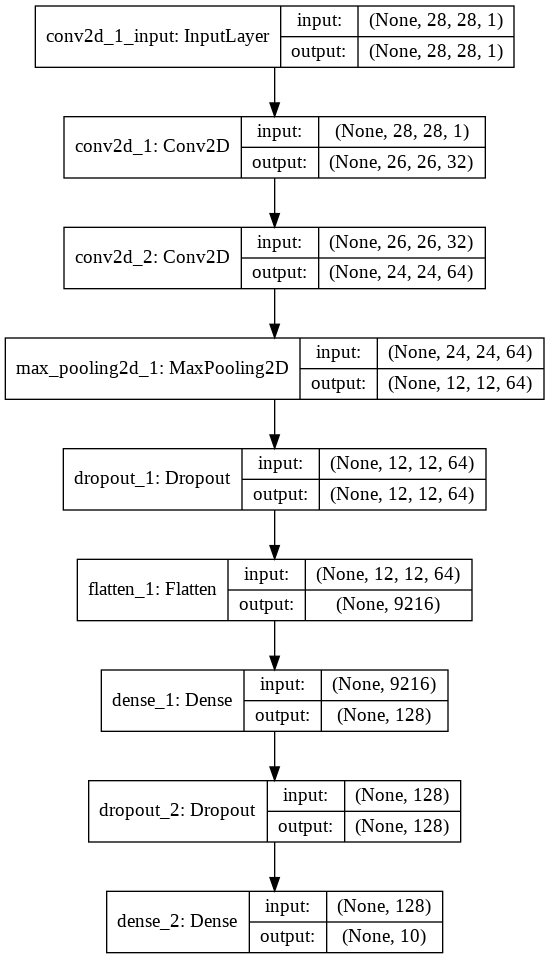

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [0]:
# history = model.fit(x_label_cnn, y_label_cnn,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test))
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [0]:
# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()